# Diving Deeper, homework

> Implementing negative prompts

In [1]:
#| default_exp diving_deeper_hw

In [2]:
#| export
from typing import List

import torch
from diffusers import LMSDiscreteScheduler, StableDiffusionPipeline
from tqdm import tqdm

from slowai.overview import TORCH_DEVICE, StableDiffusion, decompress

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Negative prompts are an extension of the Classifier Free Guidance Module. Recall this is part of the `pred_noise` method of `StableDiffusion`

In [3]:
StableDiffusion.pred_noise?

Signature: StableDiffusion.pred_noise(self, prompt_embedding, l, t, guidance_scale)
Docstring: <no docstring>
File:      ~/Code/SlowAI/slowai/overview.py
Type:      function

Let's define a helper method to load StableDiffusion, as in the "Overview" notebook

In [15]:
#| export
pipe = None


def get_simple_pipe():
    pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
    # Use a simple noising scheduler for the initial draft
    pipe.scheduler = LMSDiscreteScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )
    pipe = pipe.to(TORCH_DEVICE)
    pipe.enable_attention_slicing()
    return pipe


def get_stable_diffusion(cls=StableDiffusion):
    global pipe
    if pipe is None:
        pipe = get_simple_pipe()
    return cls(
        tokenizer=pipe.tokenizer,
        text_encoder=pipe.text_encoder,
        scheduler=pipe.scheduler,
        unet=pipe.unet,
        vae=pipe.vae,
    )

In [16]:
sd = get_stable_diffusion()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:41<00:00,  1.37s/it]


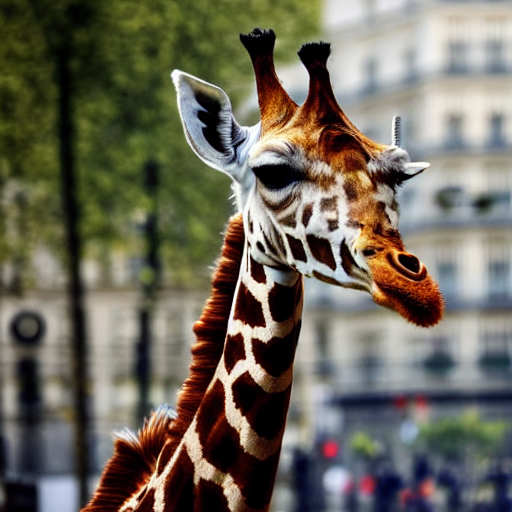

In [17]:
sd(
    prompt="a photo of a giraffe in Paris",
    guidance_scale=7.5,
    as_pil=True,
)

`prompt_embedding` is a tensor four-rank tensor of `batch_size x seq_len x channels`, where the batch size is `2` because its the concatenated unconditional prompt and the conditional prompt.

In [7]:
sd.embed_prompt("a photo of a giraffe in paris").shape

torch.Size([2, 77, 768])

We want to add the negative prompt and run this through the denoising unet at the same time. This should make the batch size into `3`.

In [18]:
# #| export
class StableDiffusionWithNegativePromptA(StableDiffusion):
    def tokenize_and_encode(self, prompt, max_length):
        prompt_tokens = sd.tokenizer(
            prompt,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )
        with torch.no_grad():
            return sd.text_encoder(
                prompt_tokens.input_ids.to(TORCH_DEVICE)
            ).last_hidden_state

    def embed_prompt(self, prompt, negative_prompt):
        pos_embedding = self.tokenize_and_encode(
            prompt, self.tokenizer.model_max_length
        )
        _, max_length, _ = pos_embedding.shape
        uncond_embedding = self.tokenize_and_encode("", max_length)
        neg_embedding = self.tokenize_and_encode(negative_prompt, max_length)
        return torch.cat([pos_embedding, uncond_embedding, neg_embedding])

In [19]:
sd = get_stable_diffusion(StableDiffusionWithNegativePromptA)
embedding = sd.embed_prompt("a photo of a giraffe in paris", "blurry")
embedding.shape

torch.Size([3, 77, 768])

Now, we need to pretty much totally rewrite the denoising method to incorporate this negative guidance.

In [20]:
#| export
class StableDiffusionWithNegativePromptB(StableDiffusionWithNegativePromptA):
    def pred_noise(
        self, prompt_embedding, l, t, guidance_scale_pos, guidance_scale_neg
    ):
        latent_model_input = torch.cat([l] * 3)
        # Scale the initial noise by the variance required by the scheduler
        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
        with torch.no_grad():
            noise_pred = self.unet(
                latent_model_input, t, encoder_hidden_states=prompt_embedding
            ).sample
        chunks = noise_pred.chunk(3)
        noise_pred_text_pos, noise_pred_uncond, noise_pred_text_neg = chunks
        return (
            noise_pred_uncond
            + guidance_scale_pos * (noise_pred_text_pos - noise_pred_uncond)
            - guidance_scale_neg * (noise_pred_text_neg - noise_pred_uncond)
        )

In [21]:
sd = get_stable_diffusion(StableDiffusionWithNegativePromptB)
embedding = sd.embed_prompt("a photo of a giraffe in paris", "blurry")
l = sd.init_latents()
epsilon = sd.pred_noise(embedding, l, t=0, guidance_scale_pos=7.5, guidance_scale_neg=2)
epsilon.shape

torch.Size([1, 4, 64, 64])

Finally, we incorporate the negative prompt into the class API.

In [22]:
#| export
class StableDiffusionWithNegativePromptC(StableDiffusionWithNegativePromptB):
    def denoise(
        self,
        prompt_embedding,
        guidance_scale_pos,
        guidance_scale_neg,
        l,  # latents
        t,  # timestep
        i,  # global progress
    ):
        noise_pred = self.pred_noise(
            prompt_embedding, l, t, guidance_scale_pos, guidance_scale_neg
        )
        return self.scheduler.step(noise_pred, t, l).prev_sample

    @torch.no_grad()
    def __call__(
        self,
        prompt,
        negative_prompt,
        guidance_scale=7.5,
        neg_guidance_scale=2,
        n_inference_steps=30,
        as_pil=False,
    ):
        prompt_embedding = self.embed_prompt(prompt, negative_prompt)
        l = self.init_latents()
        self.init_schedule(n_inference_steps)
        # Note that the time steps aren't neccesarily 1, 2, 3, etc
        for i, t in tqdm(enumerate(self.scheduler.timesteps), total=n_inference_steps):
            # workaround for ARM Macs where float64's are not supported
            t = t.to(torch.float32).to(TORCH_DEVICE)
            l = self.denoise(
                prompt_embedding, guidance_scale, neg_guidance_scale, l, t, i
            )
        return decompress(l, self.vae, as_pil=as_pil)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:14<00:00,  2.50s/it]


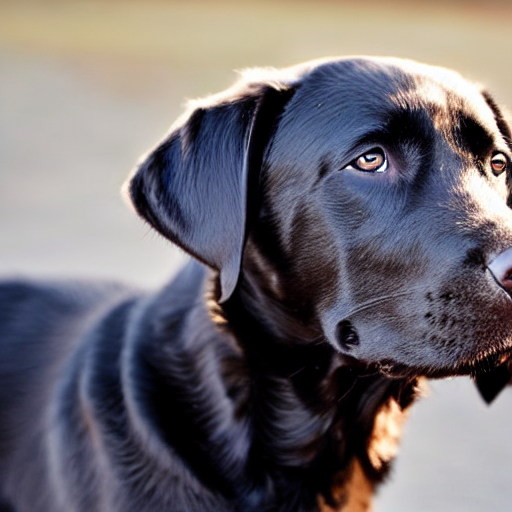

In [30]:
sd = get_stable_diffusion(StableDiffusionWithNegativePromptC)
sd(
    prompt="a photo of a labrador dog",
    negative_prompt="park, greenery, plants, flowers",
    guidance_scale=7.5,
    neg_guidance_scale=5,
    as_pil=True,
)

In [ ]:
sd = get_stable_diffusion(StableDiffusionWithNegativePromptC)
sd(
    prompt="a photo of a labrador dog in a park",
    negative_prompt="greenery, plants, flowers",
    guidance_scale=7.5,
    neg_guidance_scale=5,
    as_pil=True,
)

In [31]:
#| hide
import nbdev

nbdev.nbdev_export()